# Predicting Sea Levels
### Evaluate sea level rise over the next few years based on time-series analysis and Monte-Carlo simulation.

In [33]:
# Set up notebook headers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima.arima import auto_arima
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data Collection
Read in an Excel file containing 5 sheets which have been compiled from various sources to reflect monthly measurements between June 2000 and July 2024:
- Sea Levels: Variation in sea levels (mm) relative to June 2000. Sourced from [NASA](https://climate.nasa.gov/vital-signs/sea-level/?intent=121).
- CO2 Levels: Concentration of carbon dioxide in the atmosphere (ppm). Sourced from [NASA](https://climate.nasa.gov/vital-signs/carbon-dioxide/?intent=121).
- Temperature: Average surface temperature (deg C). Sourced from [Our World in Data](https://ourworldindata.org/grapher/monthly-average-surface-temperatures-by-year)
- Ocean Warming: Energy stored in the oceans (ZJ) relative to June 2000. Sourced from [NASA](https://climate.nasa.gov/vital-signs/ocean-warming/?intent=121)
- Polar Mass: Variation of polar mass in Antarctica (billion tons) relative to June 2000. Sourced from [EPA](https://www.epa.gov/climate-indicators/climate-change-indicators-ice-sheets) 

Note that the Sea Levels, Ocean Warming, and Polar Mass datasets contain uncertainty values which will be useful when performing Monte-Carlo simulations.

In [7]:
dataset = pd.read_excel('C:\\Users\\rohit\\OneDrive\\2024\\Sea Level Predictions\\Project_Final.xlsx', 
                        sheet_name = ['Sea Levels', 'CO2 Levels', 'Temperature', 'Ocean Warming', 'Polar Mass'])

In [30]:
unified = pd.DataFrame()
unified.index = dataset['Sea Levels']['Date']
unified['Sea Levels'] = dataset['Sea Levels']['Relative Sea Level Since 2000 (mm)'].values
unified['CO2 Levels'] = dataset['CO2 Levels']['CO2 Concentration (ppm)'].values
unified['Temperature'] = dataset['Temperature']['Average Surface Temperature (deg C)'].values
unified['Ocean Warming'] = dataset['Ocean Warming']['Ocean Warming Relative to 2000 (ZJ)'].values
unified['Polar Mass'] = dataset['Polar Mass']['Antarctica Change in Mass Relative to 2000 (Gt)'].values

#### Visualise Raw Data
View some records in each table and plot them to highlight any key trends and/or outliers.

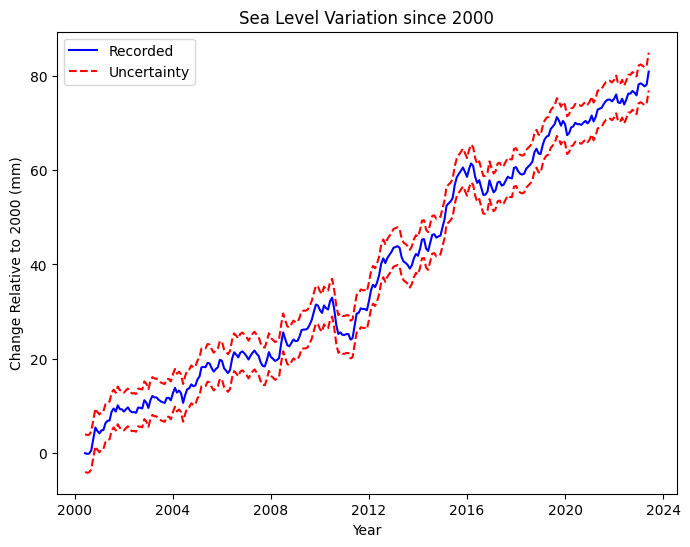

In [ ]:
# Plot sea levels over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['Sea Levels']['Date'], dataset['Sea Levels']['Relative Sea Level Since 2000 (mm)'], color = 'b',
         label = 'Recorded')
plt.plot(dataset['Sea Levels']['Date'], dataset['Sea Levels']['Lower Bound (mm)'], 
         linestyle = '--', color = 'r', label = 'Uncertainty')
plt.plot(dataset['Sea Levels']['Date'], dataset['Sea Levels']['Upper Bound (mm)'], 
         linestyle = '--', color = 'r')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (mm)')
plt.title('Sea Level Variation Since 2000')

plt.legend()

plt.show()

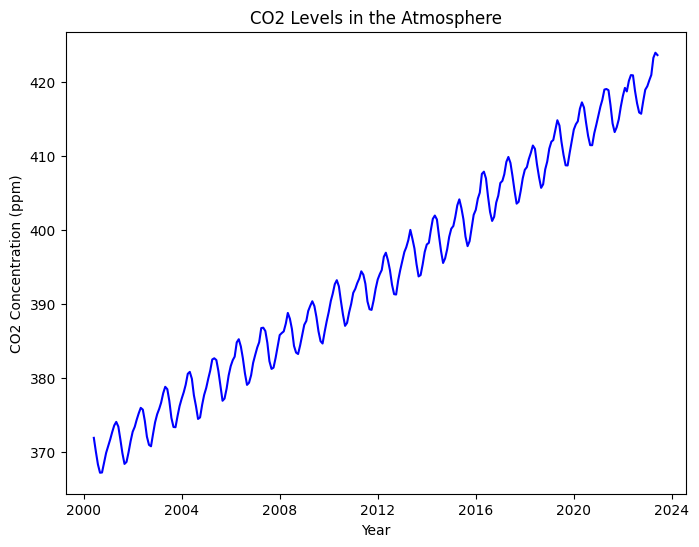

In [ ]:
# Plot CO2 levels over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['CO2 Levels']['Date'], dataset['CO2 Levels']['CO2 Concentration (ppm)'], color = 'b')

plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('CO2 Levels in the Atmosphere over Time')

plt.show()

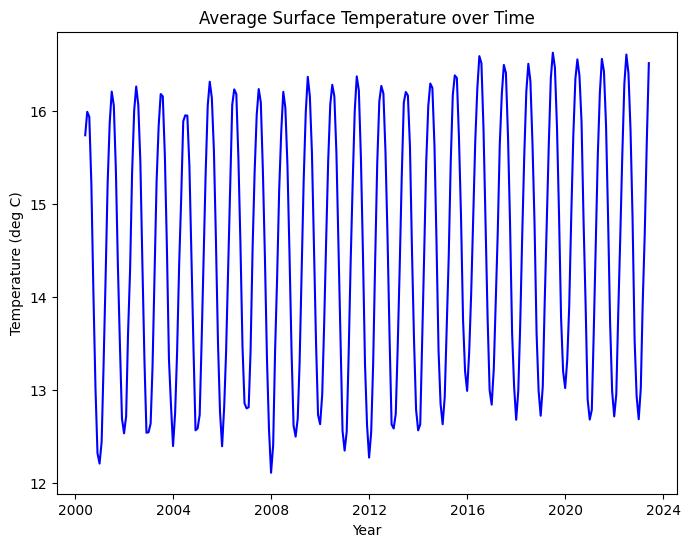

In [16]:
# Plot average temperature over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['Temperature']['Date'], dataset['Temperature']['Average Surface Temperature (deg C)'], color = 'b')

plt.xlabel('Year')
plt.ylabel('Temperature (deg C)')
plt.title('Average Surface Temperature over Time')

plt.show()

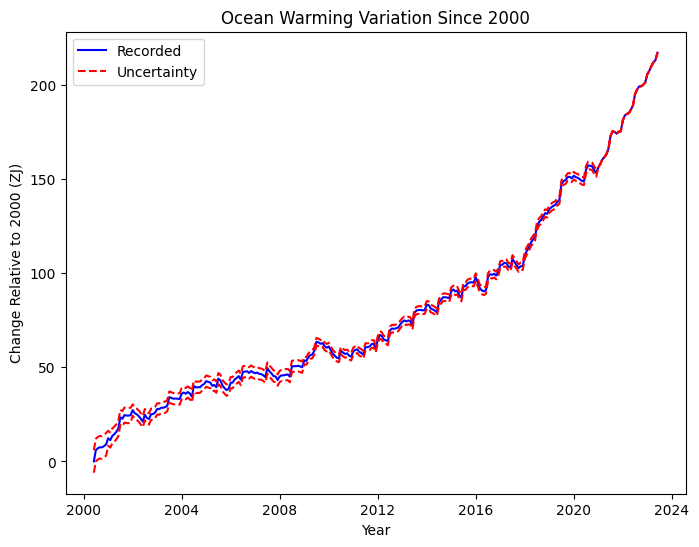

In [21]:
# Plot sea levels over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['Ocean Warming']['Date'], dataset['Ocean Warming']['Ocean Warming Relative to 2000 (ZJ)'], color = 'b',
         label = 'Recorded')
plt.plot(dataset['Ocean Warming']['Date'], dataset['Ocean Warming']['Lower Bound (ZJ)'], 
         linestyle = '--', color = 'r', label = 'Uncertainty')
plt.plot(dataset['Ocean Warming']['Date'], dataset['Ocean Warming']['Upper Bound (ZJ)'], 
         linestyle = '--', color = 'r')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (ZJ)')
plt.title('Ocean Warming Variation Since 2000')

plt.legend()

plt.show()

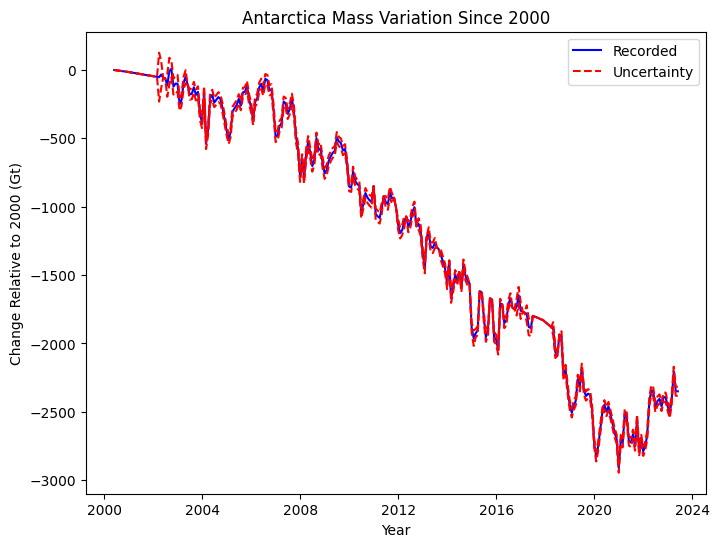

In [20]:
# Plot sea levels over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['Polar Mass']['Date'], dataset['Polar Mass']['Antarctica Change in Mass Relative to 2000 (Gt)'], color = 'b',
         label = 'Recorded')
plt.plot(dataset['Polar Mass']['Date'], dataset['Polar Mass']['Lower Bound (Gt)'], 
         linestyle = '--', color = 'r', label = 'Uncertainty')
plt.plot(dataset['Polar Mass']['Date'], dataset['Polar Mass']['Upper Bound (Gt)'], 
         linestyle = '--', color = 'r')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (Gt)')
plt.title('Antarctica Mass Variation Since 2000')

plt.legend()

plt.show()

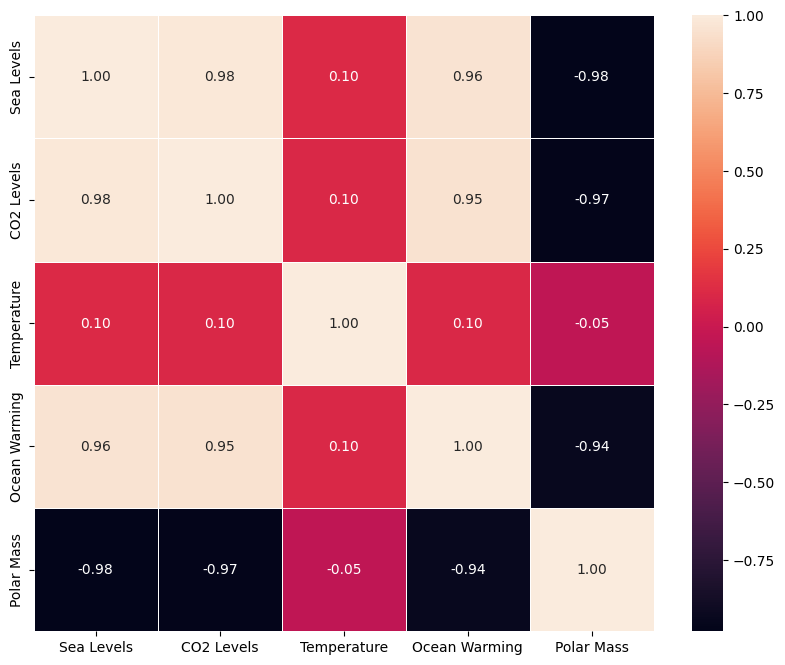

In [34]:
# See how well the "predictor" variables are correlated to sea level rise
corr = unified.corr(method = 'pearson')
 
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot = True, fmt = ".2f", linewidth = .5)
plt.show()